### Load the train/test

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

ds_name = 'resp+TB'
date = '20230310'
split_rs = '123'
ds_folder = f'/mnt/data2/chaoyue/data/{ds_name}_{date}/split_rs{split_rs}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/valid_edge.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/test.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/test_edge.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/valid_s.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/test_s.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/train_s.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/train.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/train_edge.csv
/mnt/data2/chaoyue/data/resp+TB_20230310/split_rs123/valid.csv


In [2]:
#Import the files
train_df = pd.read_csv(f'{ds_folder}/train_s.csv')
valid_df = pd.read_csv(f'{ds_folder}/valid_s.csv')
test_df = pd.read_csv(f'{ds_folder}/test_s.csv')

In [3]:
# merge train and validation
train_df = pd.concat([train_df,valid_df])

In [4]:
# get label weights
from collections import Counter
node_label = train_df['dynamic_cat'].values
label_counter = Counter(node_label)
n_samples = len(node_label)
n_classes = len(label_counter)

In [5]:
label_counter

Counter({1: 512743, 2: 1352635, 0: 3691037, 3: 38443528})

In [6]:
label_weight = {}
for i in range(3):
    label_weight[i] = (n_samples-label_counter[3]) / (3 * label_counter[i])

In [7]:
[label_weight[i] for i in range(3)]

[0.5017934887494581, 3.612215736408558, 1.3692816859931418]

### Remove the background nodes

In [8]:
train_df = train_df[train_df['cluster_id'] != 'Background']
test_df = test_df[test_df['cluster_id'] != 'Background']
print(f'Train: {train_df.shape}\nTest: {test_df.shape}')

Train: (5556415, 22)
Test: (1397162, 22)


In [9]:
test_df.tail()

,sim,cluster_id,state,dynamic,node,dynamic_cat,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,...,gamma_cat_2,gamma_cat_3,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm
1397157,10099.0,c3,B,static,295,0,0.0,0.0,0.0,1.0,...,1.0,0.0,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413
1397158,10099.0,c3,B,static,499,0,0.0,0.0,0.0,1.0,...,1.0,0.0,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413
1397159,10099.0,c3,B,static,498,0,0.0,0.0,0.0,1.0,...,1.0,0.0,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413
1397160,10099.0,c3,B,static,694,0,0.0,0.0,0.0,1.0,...,1.0,0.0,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413
1397161,10099.0,c3,B,static,2384,0,0.0,0.0,0.0,1.0,...,1.0,0.0,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413


### Load the feature desciption

In [10]:
import json
js_f = osp.join(f'../aly/feat_dict.json')

with open(js_f, 'r') as f:
    feat_desc = json.load(f)

input_feat = feat_desc['norm_onehot_feats']
print(f'Inputs: {len(input_feat)}, {input_feat}')
label_feat = 'dynamic_cat'

label_map = feat_desc['dynamic']
label_map = {int(k): v for k, v in label_map.items()}
print(label_map)

Inputs: 16, ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}


In [11]:
input_feat

['oster-norm',
 'PD-norm',
 'abs_growth_rate-norm',
 'fraction_time_growth-norm',
 'r_max-norm',
 'cherries-norm',
 'BLD-norm',
 'new_R0-norm',
 'ltt_shape_cat_0',
 'ltt_shape_cat_1',
 'ltt_shape_cat_2',
 'ltt_shape_cat_3',
 'gamma_cat_0',
 'gamma_cat_1',
 'gamma_cat_2',
 'gamma_cat_3']

In [12]:
x_train = train_df[input_feat]
y_train = train_df[label_feat]
treeid_train = train_df['sim']

x_test = test_df[input_feat]
y_test = test_df[label_feat]
treeid_test = test_df['sim']

array([[<AxesSubplot:title={'center':'oster-norm'}>,
        <AxesSubplot:title={'center':'PD-norm'}>,
        <AxesSubplot:title={'center':'abs_growth_rate-norm'}>,
        <AxesSubplot:title={'center':'fraction_time_growth-norm'}>],
       [<AxesSubplot:title={'center':'r_max-norm'}>,
        <AxesSubplot:title={'center':'cherries-norm'}>,
        <AxesSubplot:title={'center':'BLD-norm'}>,
        <AxesSubplot:title={'center':'new_R0-norm'}>],
       [<AxesSubplot:title={'center':'ltt_shape_cat_0'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_1'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_2'}>,
        <AxesSubplot:title={'center':'ltt_shape_cat_3'}>],
       [<AxesSubplot:title={'center':'gamma_cat_0'}>,
        <AxesSubplot:title={'center':'gamma_cat_1'}>,
        <AxesSubplot:title={'center':'gamma_cat_2'}>,
        <AxesSubplot:title={'center':'gamma_cat_3'}>]], dtype=object)

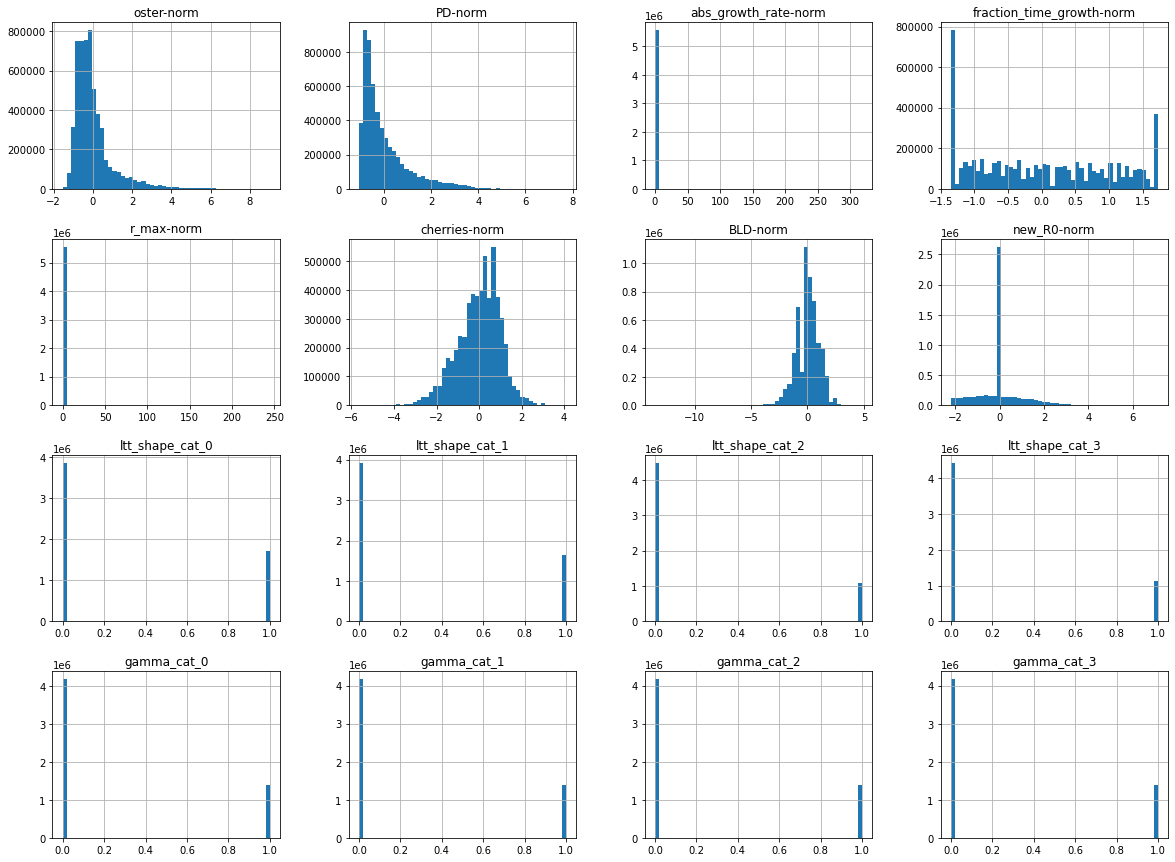

In [13]:
x_train.hist(bins=50,figsize=(20,15))

### Label distribution

Train:
static    66.428390
growth    24.343664
decay      9.227946
Name: dynamic, dtype: float64

Test:
static    66.417710
growth    24.435534
decay      9.146756
Name: dynamic, dtype: float64



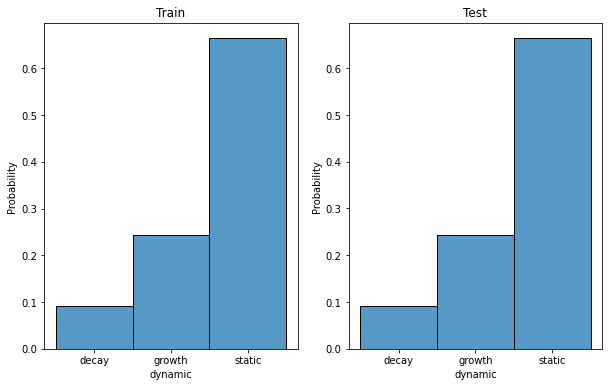

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i, (title, label_df) in enumerate(zip(['Train', 'Test'], [train_df['dynamic'], test_df['dynamic']])): 
    sns.histplot(label_df, bins='auto', stat="probability", ax=axs[i])
    axs[i].set_title(title)
    print(f'{title}:\n{label_df.value_counts(normalize=True) * 100}\n')

In [15]:
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: dynamic_cat, dtype: int64

### SMOTE and RandomOverSampler for resampling the imbalanced data

#### Get the cat features which is used for SMOTENC

In [16]:
import re

col_names = list(x_train.columns)
cat_patterns = ['ltt_shape_cat_\d*', 'gamma_cat_\d']
cat_cols_ids = []

for pattern in cat_patterns:
    for col in col_names:
        m = re.match(pattern, col)
        if m:
            idx = col_names.index(m.group(0))
            cat_cols_ids.append(idx)
            print(col_names[idx])

ltt_shape_cat_0
ltt_shape_cat_1
ltt_shape_cat_2
ltt_shape_cat_3
gamma_cat_0
gamma_cat_1
gamma_cat_2
gamma_cat_3


In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from collections import Counter
np.random.seed(0)

train_data_dict = dict()
treeid_col_idx = x_train.shape[1]  # Add the sim col to the end of the trian_df
cat_cols_ids += [treeid_col_idx]

sampler_dict = {
    'org': None,
#     'ros': RandomOverSampler(random_state=0, shrinkage=0.1), 
#     'smotenc': SMOTENC(categorical_features=cat_cols_ids, sampling_strategy='not majority', random_state=0, k_neighbors=5)
}

for sampler_name, sampler in sampler_dict.items():
    if sampler_name == 'org':
        x_train_res, y_train_res = x_train, y_train
        treeid_train = treeid_train
    elif sampler_name in ['ros', 'smotenc']:
        x_train_with_sim = pd.concat([x_train, train_df['sim']], axis=1)
        x_train_with_sim_res, y_train_res = sampler.fit_resample(x_train_with_sim, y_train)
        
        x_train_res = x_train_with_sim_res.iloc[:, :treeid_col_idx]
        treeid_train = x_train_with_sim_res['sim']
    
    train_data_dict[sampler_name] = [x_train_res, y_train_res, treeid_train]
    print(sorted(Counter(y_train_res).items()))

[(0, 3691037), (1, 512743), (2, 1352635)]


### t-SNE plot

from tsne import AlyTSNE
legend_info = deepcopy(label_map)
tsne_folder = f'../checkpoints/{ds_name}/split_rs{split_rs}/models_norm_input2/tsne'
os.makedirs(tsne_folder, exist_ok=True)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    if sampler_name == 'org':
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, perplexity=100, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    else:
        aly_train_tsne = AlyTSNE(feat=x_train_res.values, perplexity=100, label=y_train_res.values, subset='train', save_folder=f'{tsne_folder}/{sampler_name}')
        aly_train_tsne.generate_tsne(overwrite=False)
    aly_train_tsne.plot(legend_info=legend_info)

In [84]:
from random import sample
tree_ids=sample(list(treeid_test.values),30)

In [85]:
tree_ids

[2963.0,
 5977.0,
 5381.0,
 5410.0,
 4759.0,
 2175.0,
 6757.0,
 610.0,
 16058.0,
 8971.0,
 6260.0,
 6352.0,
 2573.0,
 5585.0,
 4827.0,
 2408.0,
 2799.0,
 8900.0,
 7029.0,
 11434.0,
 8057.0,
 5812.0,
 4156.0,
 5301.0,
 10607.0,
 3374.0,
 1762.0,
 18092.0,
 3837.0,
 1762.0]

In [86]:
sub_nodes = np.where(np.isin(treeid_test.values,tree_ids))

In [87]:
len(sub_nodes[0])

19335

In [88]:
x_test

,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
0,0.231626,-0.125898,-0.004350,-0.537823,-0.017638,0.426325,0.778361,0.557029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.231626,-0.125898,-0.004350,-0.537823,-0.017638,0.426325,0.778361,0.557029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.231626,-0.125898,-0.004350,-0.537823,-0.017638,0.426325,0.778361,0.557029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.231626,-0.125898,-0.004350,-0.537823,-0.017638,0.426325,0.778361,0.557029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.231626,-0.125898,-0.004350,-0.537823,-0.017638,0.426325,0.778361,0.557029,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397157,-0.652442,-0.778326,-0.004362,1.044490,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1397158,-0.652442,-0.778326,-0.004362,1.044490,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1397159,-0.652442,-0.778326,-0.004362,1.044490,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1397160,-0.652442,-0.778326,-0.004362,1.044490,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


test is done.
   label  t-SNE-1    t-SNE-2
0      0  24.8549  90.428719
1      0  24.8549  90.428719
2      0  24.8549  90.428719
3      0  24.8549  90.428719
4      0  24.8549  90.428719
('2', '1', '0')


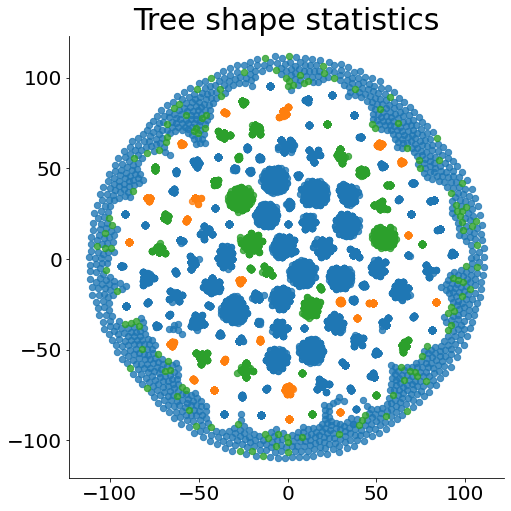

Save the plot ../checkpoints/20230326/split_rs123/models_norm_input2/tsne/org/test.svg


In [89]:
from tsne import AlyTSNE
legend_info = deepcopy(label_map)
date = '20230326'
tsne_folder = f'../checkpoints/{date}/split_rs{split_rs}/models_norm_input2/tsne'
os.makedirs(tsne_folder, exist_ok=True)
aly_test_tsne = AlyTSNE(feat=x_test.values[sub_nodes[0],:], perplexity=50, label=y_test.values[sub_nodes[0]], subset='test', save_folder=f'{tsne_folder}/org')
aly_test_tsne.generate_tsne(overwrite=False)
aly_test_tsne.plot(legend_info=legend_info)

### Cross-validation 

In [18]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GroupKFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, balanced_accuracy_score

n_folds = 5
print(f"CV: {n_folds}")


monitor_metric = None # 'f1_weighted'  # balanced_accuracy

# Set a seed for results reproduction
np.random.seed(0)

# Apply cross validation to select the best hyperparameters
# Note: cross validation split should work on the tree id, not node id.
# Incorrect: kf = KFold(n_folds,shuffle=True).split(x)

def cv_train(model, x, y, treeids):
    # TODO: verify the the groups for x
    gkf = GroupKFold(n_splits=5).split(x, groups=treeids)
    cv_val = cross_val_score(model, x, y, scoring=monitor_metric, cv=gkf)
    if not monitor_metric:
        return np.mean(cv_val), 'loss'
    return np.mean(cv_val), monitor_metric

CV: 5


In [19]:
model_folder = f'../checkpoints/{ds_name}_{date}/split_rs{split_rs}'
os.makedirs(model_folder, exist_ok=True)

In [20]:
# Onehot the label
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_auc_score, roc_curve, brier_score_loss, log_loss, precision_score, recall_score
from scipy.special import softmax

classes = np.unique(y_train)
n_classes = len(classes)
label_encode_dict = feat_desc['dynamic']

y_test_onehot = label_binarize(y_test, classes=classes)
            
def get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore):    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_test_predscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    # Micro-average: Calculate metrics globally by considering each element of the label indicator matrix as a label.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_test_predscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc

def plot_roc(n_classes, fpr, tpr, roc_auc):
    fig, axs = plt.subplots(1, 3, figsize=(25, 6))
    lw = 2

    for i, class_id in enumerate(range(n_classes)):
        ax = axs[i]
        ax.plot(fpr[class_id], tpr[class_id], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=25)
        ax.set_ylabel('True Positive Rate', fontsize=25)
        if i != 0:
            ax.set_ylabel('')
        ax.set_title(f'ROC for {label_encode_dict[str(class_id)]}-{class_id}')
        ax.legend(loc="lower right")
    plt.show()    
        
def cal_auc(y_test_onehot, y_test_predscore, metric_dict):
    macro_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                  average="macro")
    # 'weighted': Calculate metrics for each label, and find their average, 
    # weighted by support (the number of true instances for each label).
    weighted_roc_auc_ovo = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovo",
                                         average="weighted") 
    macro_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test_onehot, y_test_predscore, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))
    
    metric_dict['macro_auc_ovo'] = macro_roc_auc_ovo
    metric_dict['weighted_auc_ovo'] = weighted_roc_auc_ovo
    metric_dict['macro_auc_ovr'] = macro_roc_auc_ovr
    metric_dict['weighted_auc_ovr'] = weighted_roc_auc_ovr

In [21]:
from numpy import interp
from itertools import cycle

def plot_merged_roc(n_classes, fpr, tpr, roc_auc):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw=2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Calculate metrics for each label, and find their unweighted mean (by linear interpolation). 
    # This does not take label imbalance into account.
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


In [22]:
def brier_score(y_test_onehot, y_test_prob):
    N = y_test_onehot.shape[0]
    brier = sum(sum((y_test_onehot-y_test_prob)**2))/N
    return brier

In [36]:
from sklearn.metrics import matthews_corrcoef

def cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict):
    acc = accuracy_score(y_test, y_test_pred)
    print(f'Test Acc: {acc}')

    bal_acc = balanced_accuracy_score(y_test, y_test_pred)
    print(f'Test Ballance Acc: {bal_acc}')
    
    pr = precision_score(y_test, y_test_pred, average = 'macro')
    print(f'Test Precision: {pr}')
    
    mcc = matthews_corrcoef(y_test, y_test_pred)
    print(f'Test MCC: {mcc}')
    
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
    print(f'Test Weighted F1: {f1_weighted}')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    print(f'Test F1: {f1_macro}')
    
    brier = brier_score(y_test_onehot, y_test_predscore)
    print(f'Brier Score: {brier}')
    
    ce = log_loss(y_test, y_test_predscore)
    print(f'Cross Entropy Loss: {ce}')
    
    metric_dict['acc'] = acc
    metric_dict['balance_acc'] = bal_acc
    metric_dict['pr'] = pr
    metric_dict['mcc'] = mcc
    metric_dict['f1_weighted'] = f1_weighted
    metric_dict['f1_macro'] = f1_macro
    metric_dict['brier_score'] = brier
    metric_dict['cross_entropy'] = ce

In [24]:
def eval_classifer(model, x_test, y_test, metric_dict):
    y_test_pred = model.predict(x_test)
    y_test_predscore = model.predict_proba(x_test)
    y_test_onehot = label_binarize(y_test, classes=classes)
    
    cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(n_classes, y_test_onehot, y_test_predscore)
    plot_roc(n_classes, fpr, tpr, roc_auc)
    plot_merged_roc(n_classes, fpr, tpr, roc_auc)

In [25]:
def get_best_classifer(model, cv_func, x_train, y_train, treeid_train, x_test, y_test, label_weight, metric_dict):
    model.fit(x_train, y_train, cv_func, treeid_train, label_weight)
    model.best_classifer.fit(x_train, y_train)
    return model.best_classifer

### Softmax regression

In [26]:
from base_model import Sfmx
from collections import defaultdict
from joblib import dump, load
plt.rcParams['font.size'] = 12

In [27]:
# load model if it is trained
model_dict = load(osp.join(model_folder, f'sfmx.joblib'))
model_dict

{'org': LogisticRegression(C=1000.0,
                    class_weight={0: 0.5017934887494581, 1: 3.612215736408558,
                                  2: 1.3692816859931418},
                    max_iter=5000, multi_class='multinomial',
                    solver='newton-cg')}

===Model for org data===


/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/o

/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/pyt

/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/pyt

/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/pyt

best validation loss achieved: 0.46858578963840936


/home/chaoyue/anaconda3/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/chaoyue/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Test Acc: 0.46602398290248376
Test Ballance Acc: 0.5247430016941408
Test Precision: 0.4371726299751359
Test Recall: 0.5247430016941408
Test Weighted F1: 0.4924360323093141
Test F1: 0.42886479856387494
Brier Score: 0.6141534077227097
Cross Entropy Loss: 1.0164145193776346
One-vs-One ROC AUC scores:
0.674876 (macro),
0.648585 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.674876 (macro),
0.648585 (weighted by prevalence)


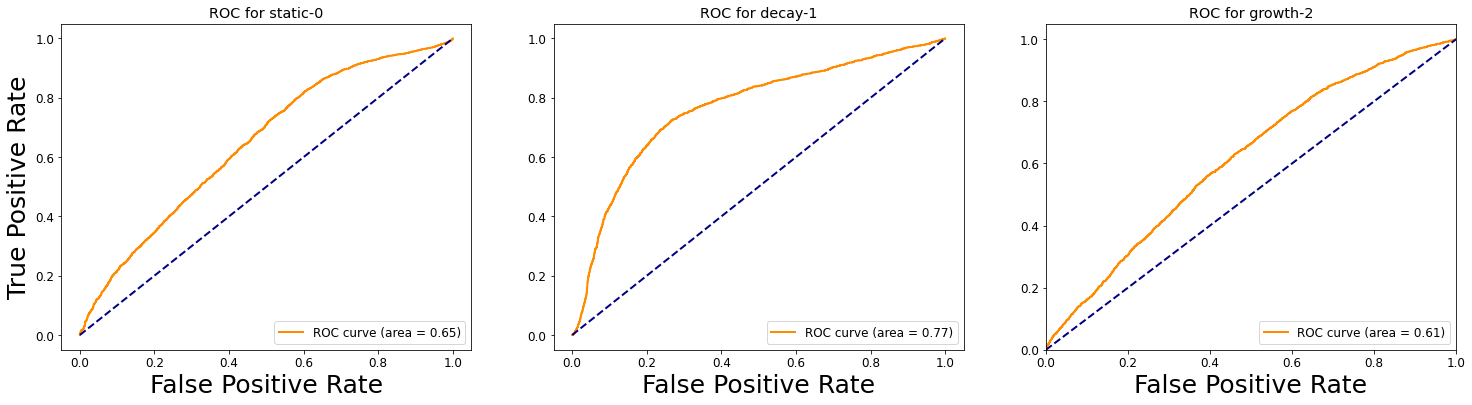

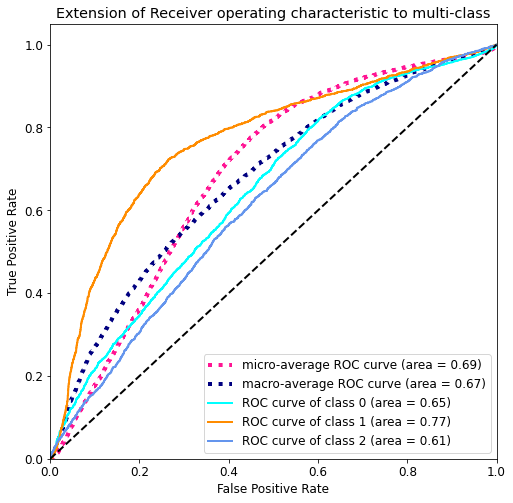

In [36]:
# train a new model
from base_model import Sfmx
from collections import defaultdict

sfmx_model_dict = dict()
sfmx_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    print(f"===Model for {sampler_name} data===")
    
    np.random.seed(0)
    model = Sfmx()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, label_weight, sfmx_metric_dict)
    sfmx_metric_dict['model'].append('softmax')
    sfmx_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, sfmx_metric_dict)
    sfmx_model_dict[sampler_name] = best_model
    print('\n')
linear_best_model = best_model

sfmx_metric_df = pd.DataFrame.from_dict(sfmx_metric_dict)
sfmx_metric_df

### Analyze the mis-classcification 

In [28]:
def get_misclass(y_true, y_pred):
    mis_id_dict = defaultdict(dict)
    mis_ids = y_true != y_pred
    print(f'Total Mis: {sum(mis_ids)}, ({100 * sum(mis_ids) / len(y_true):.3f}%)')
    
    print(label_map)
    for i in range(len(label_map)):
        label_ids = y_true == i
        sub_mis_id_dict = defaultdict(list)
        
        for idx, (label_id, mis_id) in enumerate(zip(label_ids, mis_ids)):
            if label_id and mis_id:
                sub_mis_id_dict[y_pred[idx]].append(idx)
        
        n_mis = sum([len(mis_lst) for mis_lst in sub_mis_id_dict.values()])
        n_sample = sum(label_ids)
        
        print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')
        for mis_label, mis_lst in sub_mis_id_dict.items():
            print(f'\t{mis_label}: {len(mis_lst)}')
        
        mis_id_dict[i] = sub_mis_id_dict
    return mis_id_dict

In [29]:
best_model = model_dict['org']

In [30]:
y_test_pred = best_model.predict(x_test)
y_test_predscore = best_model.predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 746051, (53.398%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 520964/927963, (56.141%)
	2: 327365
	1: 193599
Mis-classified of decay: 41885/127795, (32.775%)
	2: 21124
	0: 20761
Mis-classified of growth: 183202/341404, (53.661%)
	0: 111578
	1: 71624
Mis-classified of bg: 0/0, (nan%)


/tmp/ipykernel_32541/2063171099.py:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


In [31]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_arr, y_test_pred)
conf_mat

array([[406999, 193599, 327365],
       [ 20761,  85910,  21124],
       [111578,  71624, 158202]])

In [32]:
label_map

{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}

In [33]:
labels = [label_map[label_id] for label_id in classes]

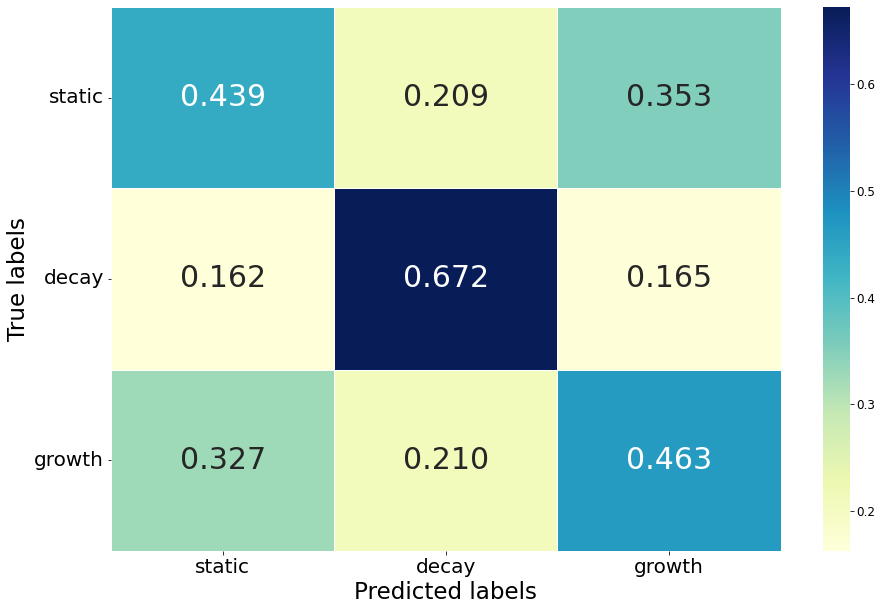

In [34]:
conf_mat = confusion_matrix(y_test_arr, y_test_pred, normalize="true")
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu", ax=ax, annot_kws={"fontsize":30})
ax.set_ylabel('True labels', fontsize=23)
ax.set_xlabel('Predicted labels', fontsize=23)

ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
plt.show()
#fig.savefig(osp.join(save_path, f"confusion_mat.png"))

Test Acc: 0.46602398290248376
Test Ballance Acc: 0.5247430016941408
Test Precision: 0.4371726299751359
Test MCC: 0.17272751212622778
Test Weighted F1: 0.4924360323093141
Test F1: 0.42886479856387494
Brier Score: 0.6141534077227097
Cross Entropy Loss: 1.0164145193776346
One-vs-One ROC AUC scores:
0.674876 (macro),
0.648585 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.674876 (macro),
0.648585 (weighted by prevalence)


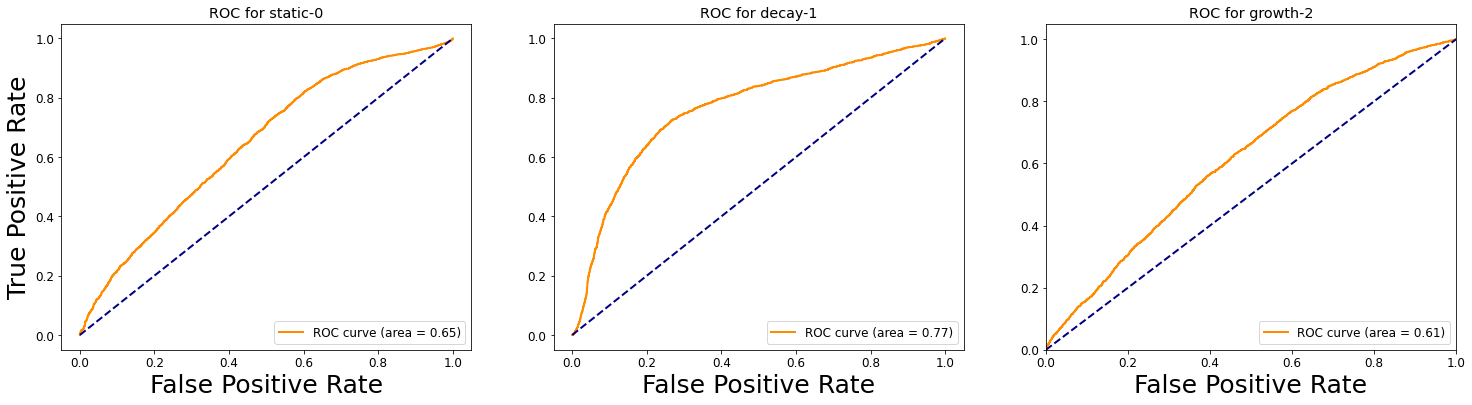

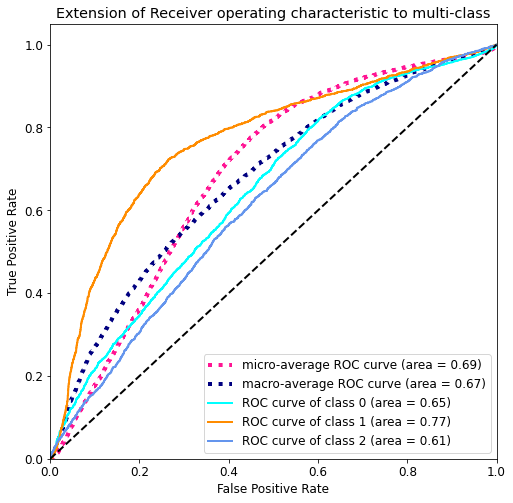

In [37]:
sfmx_metric_dict = defaultdict(list)
eval_classifer(best_model, x_test, y_test, sfmx_metric_dict)

### Save the model 

In [44]:
from joblib import dump, load

def save(model_dict, model_name):
    dump(model_dict, osp.join(model_folder, f'{model_name}.joblib'))

In [45]:
save(sfmx_model_dict, 'sfmx')

### Random Forest

In [42]:
#import from trained model
model_dict = load(osp.join(model_folder, f'rf.joblib'))
best_model = model_dict['org']
model_dict['org']

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=12, min_samples_split=9,
                       n_estimators=70)

In [39]:
#adjust weights for labels
rf_label_weight = label_weight

In [40]:
rf_label_weight

{0: 0.5017934887494581, 1: 3.612215736408558, 2: 1.3692816859931418}

===Model for org data===
best validation loss achieved: 0.4806730419877366
Test Acc: 0.4931346543922609
Test Ballance Acc: 0.5687092184092304
Test Precision: 0.4792420963913515
Test Recall: 0.5687092184092304
Test Weighted F1: 0.5120036531293857
Test F1: 0.46900122754310725
Brier Score: 0.5812482757550821
Cross Entropy Loss: 0.9490301474571117
One-vs-One ROC AUC scores:
0.709030 (macro),
0.675823 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.709030 (macro),
0.675823 (weighted by prevalence)


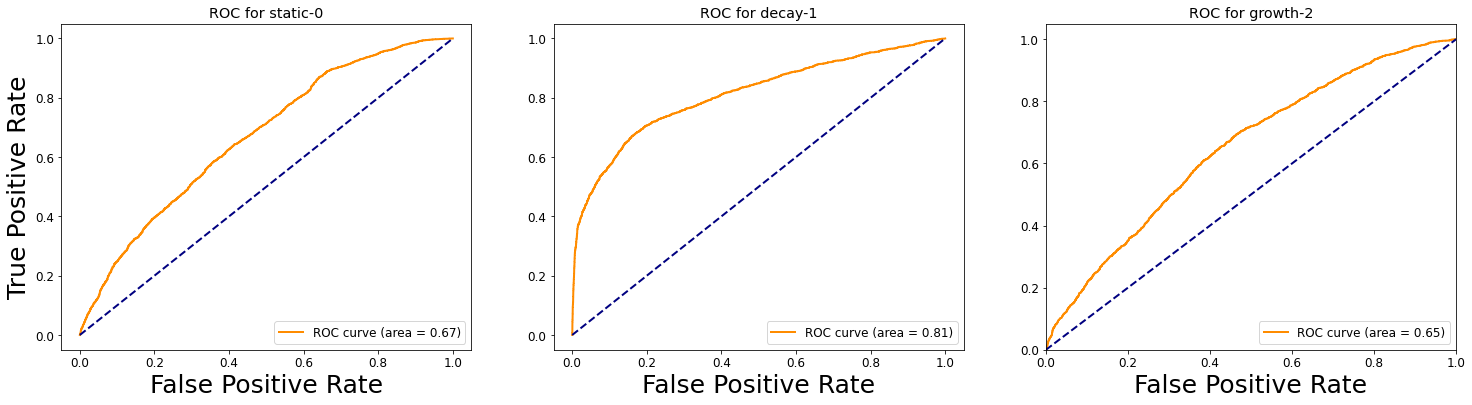

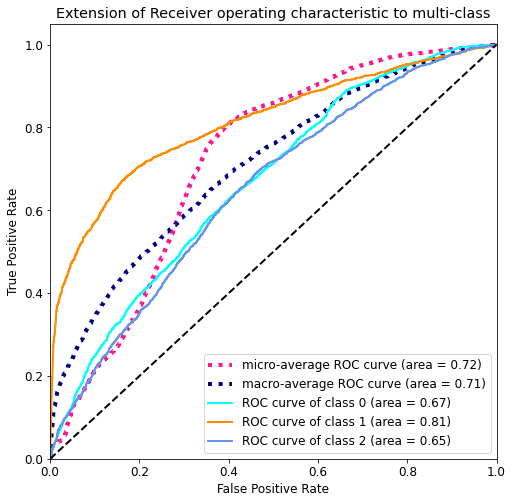

In [48]:
from base_model import RF
from collections import defaultdict

rf_model_dict = dict()
rf_metric_dict = defaultdict(list)

for sampler_name, (x_train_res, y_train_res, treeid_train) in train_data_dict.items():
    np.random.seed(0)
    print(f"===Model for {sampler_name} data===")
    
    model = RF()
    best_model = get_best_classifer(model, cv_train, x_train_res, y_train_res, treeid_train, 
                                    x_test, y_test, rf_label_weight, rf_metric_dict)
    rf_metric_dict['model'].append('rf')
    rf_metric_dict['sampler_name'].append(sampler_name)
    eval_classifer(best_model, x_test, y_test, rf_metric_dict)
    rf_model_dict[sampler_name] = best_model
    print('\n')

### Analyze the mis-classcification 

Total Mis: 708173, (50.687%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 535477/927963, (57.705%)
	2: 392167
	1: 143310
Mis-classified of decay: 43094/127795, (33.721%)
	0: 22750
	2: 20344
Mis-classified of growth: 129602/341404, (37.961%)
	0: 78358
	1: 51244


/tmp/ipykernel_32541/2063171099.py:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


Mis-classified of bg: 0/0, (nan%)


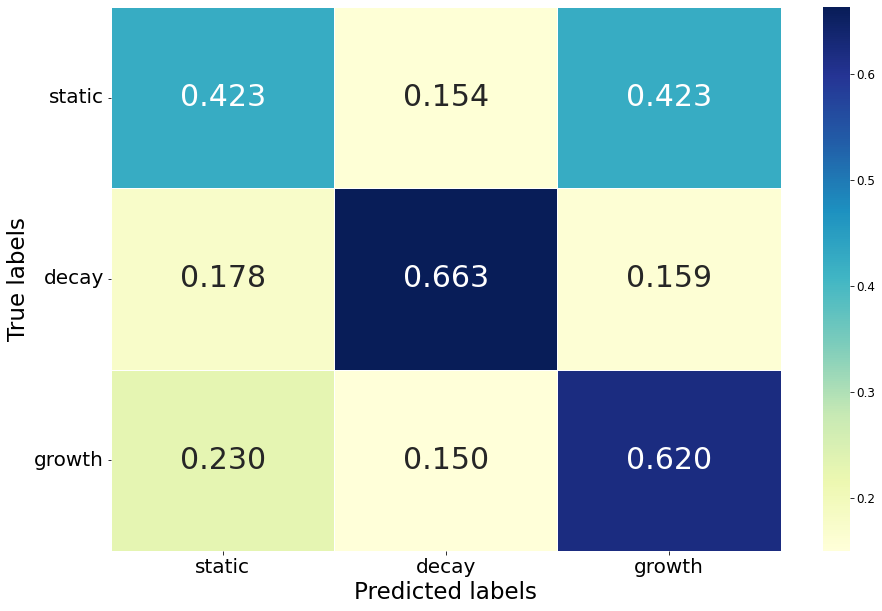

In [43]:
y_test_pred = best_model.predict(x_test)
y_test_predscore = best_model.predict_proba(x_test)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

conf_mat = confusion_matrix(y_test_arr, y_test_pred, normalize="true")
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu", ax=ax, annot_kws={"fontsize":30})
ax.set_ylabel('True labels', fontsize=23)
ax.set_xlabel('Predicted labels', fontsize=23)

ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
plt.show()


### save model

In [50]:
rf_model_dict[sampler_name] = best_model
dump(rf_model_dict, osp.join(model_folder, f'rf.joblib'))

['../checkpoints/resp+TB_20230310/split_rs123/rf.joblib']

Test Acc: 0.4931346543922609
Test Ballance Acc: 0.5687092184092304
Test Precision: 0.4792420963913515
Test MCC: 0.23459065165836832
Test Weighted F1: 0.5120036531293857
Test F1: 0.46900122754310725
Brier Score: 0.5812482757550821
Cross Entropy Loss: 0.9490301474571117
One-vs-One ROC AUC scores:
0.709030 (macro),
0.675823 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.709030 (macro),
0.675823 (weighted by prevalence)


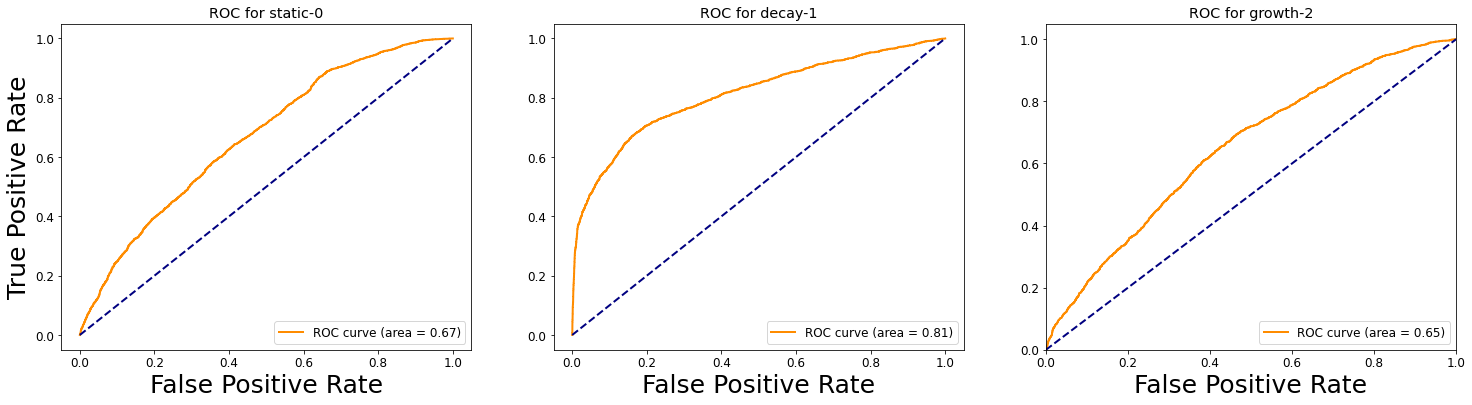

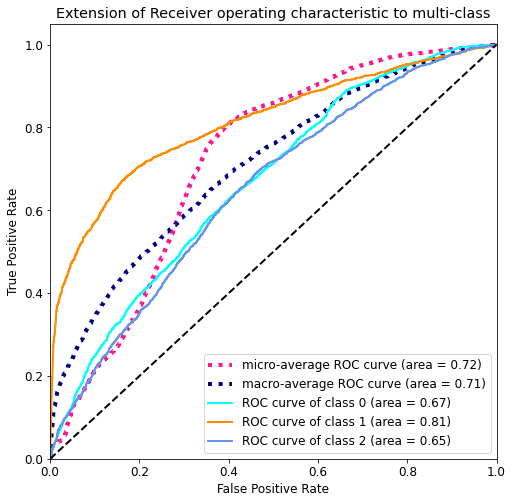

In [44]:
rf_model_dict = load(osp.join(model_folder, f'rf.joblib'))
rf_metric_dict = defaultdict(list)
eval_classifer(rf_model_dict['org'], x_test, y_test, rf_metric_dict)

In [52]:
# Merget the test data and prediction
y_test_true_df = pd.DataFrame({'true': y_test})
y_test_pred_df = pd.DataFrame({'pred': y_test_pred})
test_pred_df = pd.concat([x_test, y_test_true_df, y_test_pred_df], axis=1)
test_pred_df.to_csv(osp.join(model_folder, 'rf_org_pred.csv'), index=False)

test_pred_df.tail()

,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,new_R0-norm,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,true,pred
1397157,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2
1397158,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2
1397159,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2
1397160,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2
1397161,-0.652442,-0.778326,-0.004362,1.04449,-0.039603,-2.912774,-0.287726,0.755413,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,2


### XGBoost

In [45]:
def eval_xgb_classifer(model, d_test, x_test, y_test, metric_dict):
    y_test_predscore = model.predict(d_test)
    y_test_pred = np.argmax(y_test_predscore,axis=1)
    y_test_onehot = label_binarize(y_test, classes=classes)
    
    cal_basic_metric(y_test, y_test_pred, y_test_onehot, y_test_predscore, metric_dict)
    cal_auc(y_test_onehot, y_test_predscore, metric_dict)
    
    fpr, tpr, roc_auc = get_fpr_tpr(3, y_test_onehot, y_test_predscore)
    plot_roc(n_classes, fpr, tpr, roc_auc)
    plot_merged_roc(n_classes, fpr, tpr, roc_auc)

label_weight = {}
for i in range(n_classes):
    label_weight[i] = n_samples / (n_classes * label_counter[i])

In [46]:
label_weight

{0: 0.5017934887494581, 1: 3.612215736408558, 2: 1.3692816859931418}

In [47]:
xgb_weight=label_weight

In [62]:
xgb_weight[0] -= 0.4

In [48]:
xgb_train_weight = np.array([xgb_weight[i] for i in y_train_res])
xgb_test_weight = np.array([xgb_weight[i] for i in y_test])

In [64]:
xgb_weight

{0: 0.10179348874945804, 1: 3.612215736408558, 2: 1.3692816859931418}

best validation mlogloss achieved: [0.9476446]
{'learning_rate': 0.07, 'subsample': 0.07786712570949134, 'lambda': 1.0, 'max_depth': 20, 'objective': 'multi:softprob', 'verbosity': 0, 'num_class': 3}
Test Acc: 0.47376539012655655
Test Ballance Acc: 0.5475455678575908
Test Precision: 0.4717968526143155
Test Recall: 0.5475455678575908
Test Weighted F1: 0.487923258155745
Test F1: 0.4537770025160985
Brier Score: 0.6181972251192093
Cross Entropy Loss: 1.0228521741143315
One-vs-One ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)


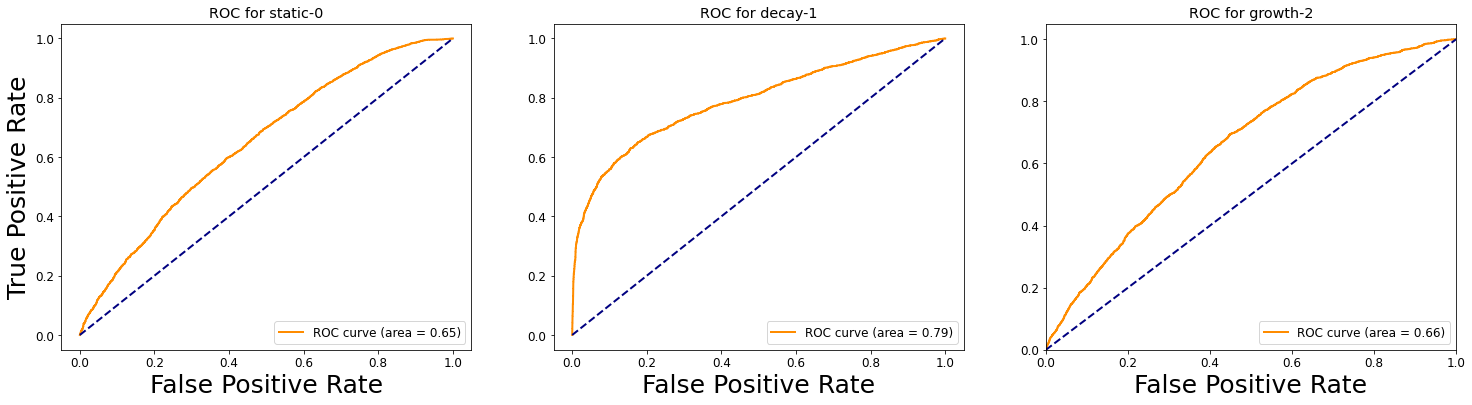

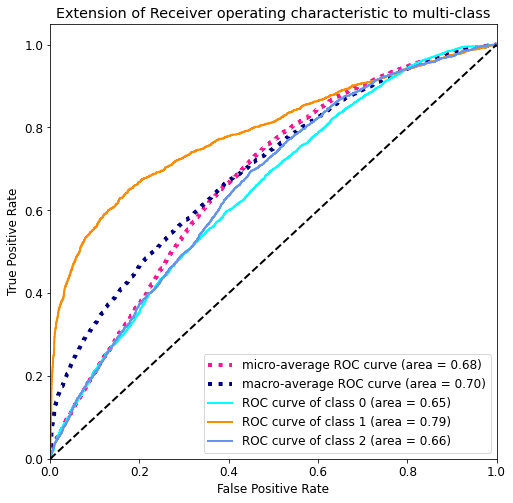

In [65]:
# train a new model
from base_model import XGB
import xgboost as xgb
from collections import defaultdict

d_train = xgb.DMatrix(x_train_res, label = y_train_res, weight = xgb_train_weight)
d_test = xgb.DMatrix(x_test, label = y_test, weight = xgb_test_weight)
xgb_model_dict = dict()
xgb_metric_dict = defaultdict(list)
model = XGB()
cv_results = model.weighted_train(d_train, monitor_metric, treeid_train)
print(model.best_classifier)
best_model = xgb.train(params=model.best_classifier, dtrain=d_train)
xgb_metric_dict['model'].append('xgb')
xgb_model_dict['best_model'] = best_model
eval_xgb_classifer(best_model, d_test, x_test, y_test, xgb_metric_dict)

Test Acc: 0.47376539012655655
Test Ballance Acc: 0.5475455678575908
Test Precision: 0.4717968526143155
Test MCC: 0.21446125628410026
Test Weighted F1: 0.487923258155745
Test F1: 0.4537770025160985
Brier Score: 0.6181972251192093
Cross Entropy Loss: 1.0228521741143315
One-vs-One ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)


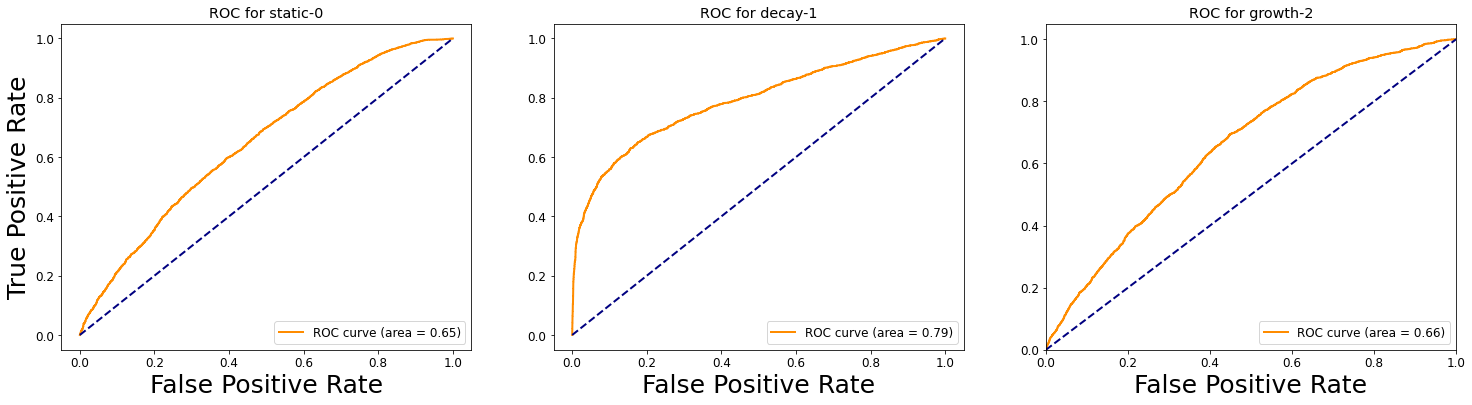

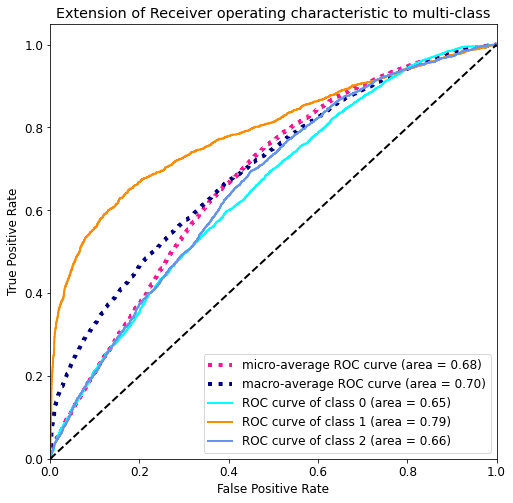

In [49]:
# import a trained model
from base_model import XGB
import xgboost as xgb
from joblib import dump, load
d_test = xgb.DMatrix(x_test, label = y_test, weight = xgb_test_weight)
xgb_metric_dict = defaultdict(list)
model_dict = load(osp.join(model_folder, f'xgb.joblib'))
eval_xgb_classifer(model_dict['best_model'], d_test, x_test, y_test, xgb_metric_dict)
best_model = model_dict['best_model']

### Analyze the mis-classcification 

In [66]:
y_test_predscore = best_model.predict(d_test)
y_test_pred = np.argmax(y_test_predscore,axis=1)
y_test_arr = y_test.values

mis_id_dict = get_misclass(y_test_arr, y_test_pred)

Total Mis: 735235, (52.623%)
{0: 'static', 1: 'decay', 2: 'growth', 3: 'bg'}
Mis-classified of static: 569331/927963, (61.353%)
	2: 433647
	1: 135684
Mis-classified of decay: 52674/127795, (41.218%)
	2: 29913
	0: 22761
Mis-classified of growth: 113230/341404, (33.166%)
	0: 79021
	1: 34209
Mis-classified of bg: 0/0, (nan%)


/tmp/ipykernel_18023/2063171099.py:18: RuntimeWarning: invalid value encountered in long_scalars
  print(f'Mis-classified of {label_map[i]}: {n_mis}/{n_sample}, ({100 * n_mis / n_sample:.3f}%)')


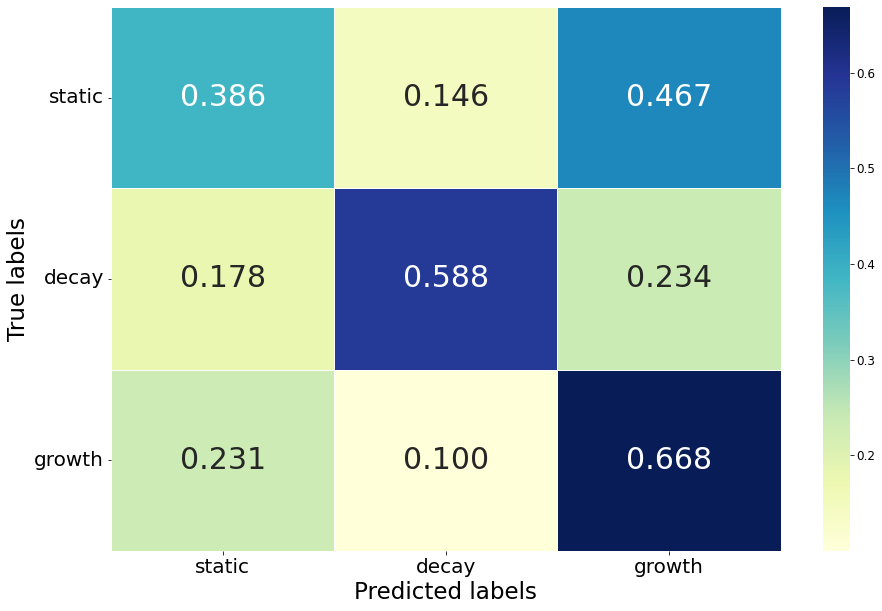

In [67]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_arr, y_test_pred, normalize="true")
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu", ax=ax, annot_kws={"fontsize":30})
ax.set_ylabel('True labels', fontsize=23)
ax.set_xlabel('Predicted labels', fontsize=23)

ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")
plt.show()


In [68]:
from xgboost import plot_importance, plot_tree

def plot_impt(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 20))

    # Feature importance type: 
    # "gain" is the average gain of splits which use the feature
    # "weight" is the number of times a feature appears in a tree

    for i, impt_type in enumerate(['gain', 'weight']): 
        ax = plot_importance(model, importance_type=impt_type, ax=axs[i], show_values=False)
        ax.set_title(f'Feature importance: {impt_type}')
    plt.show()

In [69]:
for sampler_type in train_data_dict.keys():
    plot_impt(model_dict['best_model'])
    break

NameError: name 'model_dict' is not defined

In [70]:
save(xgb_metric_dict,'xgb')
dump(xgb_model_dict, osp.join(model_folder, f'xgb.joblib'))

['../checkpoints/resp+TB_20230310/split_rs123/xgb.joblib']

Test Acc: 0.47376539012655655
Test Ballance Acc: 0.5475455678575908
Test Precision: 0.4717968526143155
Test Recall: 0.5475455678575908
Test Weighted F1: 0.487923258155745
Test F1: 0.4537770025160985
Brier Score: 0.6181972251192093
Cross Entropy Loss: 1.0228521741143315
One-vs-One ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.699073 (macro),
0.663414 (weighted by prevalence)


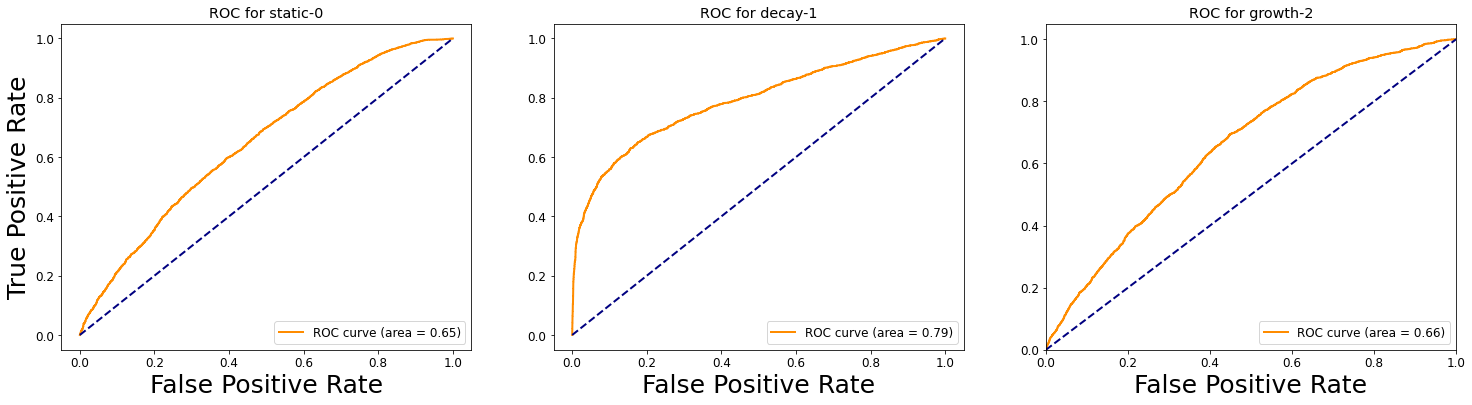

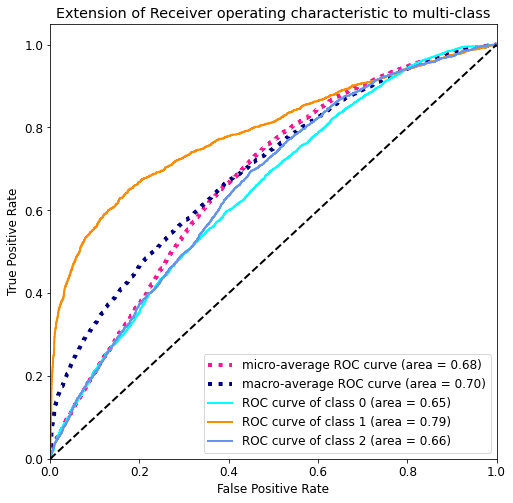

In [71]:
xgb_metric_dict = defaultdict(list)
model_dict = load(osp.join(model_folder, f'xgb.joblib'))
eval_xgb_classifer(model_dict['best_model'], d_test, x_test, y_test, xgb_metric_dict)